---

<div style="text-align: center;">
    <h2><strong>MOVIE MOOSE</strong></h2>
    <h2><strong> A Movie Recommendation System </strong></h2>
    <img src="logo.png" width="200"/>
    <h3> Final Project E178 - SDSE </h3>
     <p> Carlson Jansen (3037907979) </p>
     <p> Clarissa Suwoko (3038120659) </p>
     <p> Li Li (3038159711) </p>
     <p> Giovanni Wong (3036553729) </p>
</div>

---



<h1>Legends</h1>
0. Objectives<br />
1. Import and Analyze Datasets<br />
&nbsp;&nbsp; &nbsp;1.1. Import libraries, read csv, and check csv<br />
&nbsp;&nbsp; &nbsp;1.2. Summarize Dataset Information<br />
2. Modyfing Dataframe<br />
&nbsp;&nbsp; &nbsp;2.1. Combine two dataframes<br />
&nbsp;&nbsp; &nbsp;2.2. Create a pivot table<br />
&nbsp;&nbsp; &nbsp;2.3. Cleaning noises<br />
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;2.3.1. Exploratory Data Analysis (Item-Based Collaborative Filtering)<br />
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;2.3.2. Exploratory Data Analysis (User-Based Collaborative Filtering)<br />
3. Method-based Next Steps<br />
&nbsp;&nbsp; &nbsp;3.1. Item-Based Collaborative Filtering Next Steps<br />
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;3.1.1. Removing Sparsity<br />
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;3.1.2. Compute Similarity - KNN Algorithm<br />
&nbsp;&nbsp; &nbsp;3.2. Item-Based Collaborative Filtering<br />
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;3.2.1. Create User-Movie Matrix<br />
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;3.2.2. Normalize User-Movie Matrix<br />
&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;3.2.3. Compute Similarity - Pearson Correlation<br />
4. Getting Recommendation Function<br />
5. Calling the Recommendation Function</p>


<h1>0. Objectives</h1>

<p>The primary objective is to compare the effectiveness of user-based and item-based collaborative filtering in a movie recommendation system.</p>

<p>1. Item-based collaborative filtering:</p>

<ul>
	<li><strong>Process</strong>: It involves computing similarity scores between items based on user ratings or interactions.</li>
	<li><strong>Recommendation Logic</strong>: If a user likes a particular movie, the system recommends movies that are similar to that one, based on how other users have interacted with them.</li>
</ul>

<p>2. User-based collaborative filtering;</p>

<ul>
	<li><strong>Process</strong>: It works by finding users who have similar preferences or viewing histories to the target user.</li>
	<li><strong>Recommendation Logic</strong>: If User A likes certain movies and User B has a similar taste profile, the system assumes User B will also like movies that User A enjoys2.&nbsp;</li>
</ul>

# 1. Import and Analyze Datasets

## 1.1. Import libraries, read csv, and check csv

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Load the movie and ratings data
movies = pd.read_csv("./ml-latest-small/movies.csv")
ratings = pd.read_csv("./ml-latest-small/ratings.csv")

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


## 1.2. Summarize Dataset Information

In [6]:
# Number of users
print('Unique users:', ratings['userId'].nunique())

# Number of movies
print('Unique movies:', ratings['movieId'].nunique())

# Number of ratings
print('Unique # of ratings:', ratings['rating'].nunique())

# List of unique ratings
print('Unique ratings value:', sorted(ratings['rating'].unique()))

Unique users: 610
Unique movies: 9724
Unique # of ratings: 10
Unique ratings value: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# 2. Modifying Dataframe

## 2.1. Combine two dataframes
Both `ratings.csv` and `movies.csv` are combined into `combined_df` so we can refer to the movie's title with the corresponding movie ID.

In [7]:
# Merge ratings and movies datasets
combined_df = pd.merge(ratings, movies, on='movieId', how='inner')

# Check the combined_df
combined_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## 2.2. Create a pivot table
Create a pivot table for both item-based method

In [8]:
# Creating a pivot table (Item-based) from the ratings data
item_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
item_dataset.fillna(0,inplace=True)
item_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.3 Cleaning Noises


### 2.3.1. Exploratory Data Analysis (Item-Based Collaborative Filtering)

- To qualify a movie, a minimum of 10 users should have voted a movie.

- To qualify a user, a minimum of 50 movies should have voted by the user.

In [9]:
# Aggregate data
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

agg_data = pd.DataFrame({
    'no_user_voted': no_user_voted,
    'no_movies_voted': no_movies_voted
}).reset_index()

In [10]:
# Filter the aggregated data
agg_data_filtered = agg_data[(agg_data['no_user_voted'] > 10) & (agg_data['no_movies_voted'] > 50)]

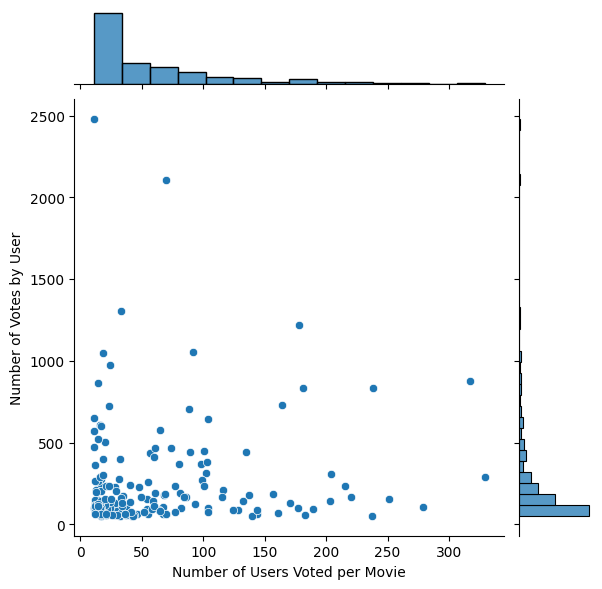

In [11]:
# Visualization
sns.jointplot(x='no_user_voted', y='no_movies_voted', data=agg_data_filtered)
plt.xlabel('Number of Users Voted per Movie')
plt.ylabel('Number of Votes by User')
plt.show()

In [12]:
item_dataset = item_dataset.loc[no_user_voted[no_user_voted > 10].index,:]
item_dataset = item_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
item_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



## 2.3.2. Exploratory Data Analysis (User-based Collaborative Filtering)

- Group the movies by title, count the number of ratings, and keep only the movies with greater than 10 ratings.

- Calculate the average ratings for the movies as well.

In [13]:
# Aggregate by movie
agg_ratings = combined_df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with greater than 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>10]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2121 entries, 6 to 9717
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2121 non-null   object 
 1   mean_rating        2121 non-null   float64
 2   number_of_ratings  2121 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 66.3+ KB


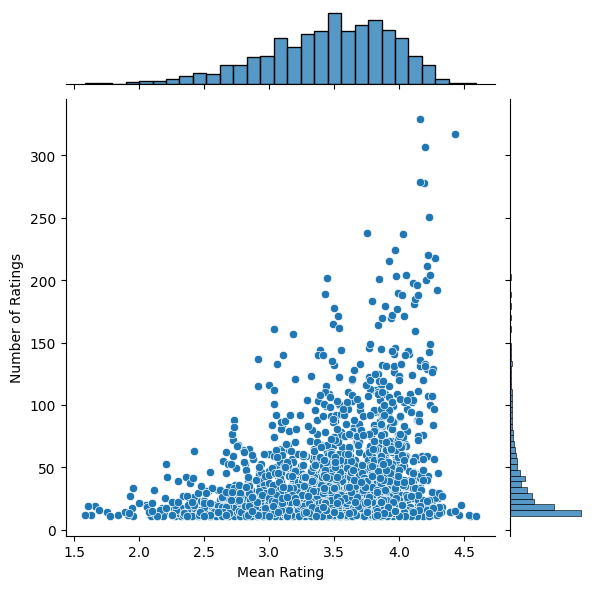

In [14]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)
plt.xlabel('Mean Rating')
plt.ylabel('Number of Ratings')
plt.show()

In [15]:
# Merge data
GT100_df = pd.merge(combined_df, agg_ratings_GT100[['title']], on='title', how='inner')
GT100_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79640 entries, 0 to 79639
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     79640 non-null  int64  
 1   movieId    79640 non-null  int64  
 2   rating     79640 non-null  float64
 3   timestamp  79640 non-null  int64  
 4   title      79640 non-null  object 
 5   genres     79640 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 3.6+ MB


# 3. Method-based Next Steps
Here, the two methods of item-based and user-based collaborative filtering will undergo a different path to reach the final recommendation system. 

Let's start with item-based collaborative filtering.

## 3.1. Item-based Collaborative Filtering Next Steps

### 3.1.1. Removing Sparsity

The `item_dataset` is a sparse matrix with the size of 2121 by 378. Although this is a relatively small dataset, the original, much larger dataset from MovieLens contains over 100,000 features, which could potentially exhaust our system's computational capabilities if fed into the model as is. 

To mitigate this issue of sparsity, we employ the `csr_matrix` function from the scipy library.

In [16]:
csr_data = csr_matrix(item_dataset.values)
item_dataset.reset_index(inplace=True)

### 3.1.2. Compute Similarity - K Nearest Neighbor Algorithm
We will be using the KNN algorithm to compute similarity with cosine distance

In [17]:
# Nearest Neighbors model for recommendations
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# Fit the model
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

## 3.2. User-based Collaborative Filtering Next Steps

### 3.2.1. Create User-Movie Matrix

In [18]:
matrix = GT100_df.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2.2. Normalize User-Movie Matrix
To account for the variability in rating tendencies among different users, we normalize the ratings by subtracting the average rating of each user from their individual ratings.

As a result of this normalization process, movies rated below a user's average receive a negative value, while those rated above the average receive a positive value.


In [19]:
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.38756
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.980769,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.40678,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2.3. Compute Similarity - Pearson Correlation
We will calculate the user similarity matrix using Pearson correlation.

In [20]:
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,0.079819,0.207983,0.268749,-0.291636,-0.118773,0.469668,0.918559,-0.037987,...,0.091574,1.183502e-17,-0.062468,-0.407556,-0.189246,0.068789,0.158524,0.268362,-0.175412,-0.032086
2,NaN,1.0,NaN,NaN,NaN,NaN,-0.991241,NaN,NaN,0.037796,...,-0.387347,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.125000,NaN,0.623288
3,0.079819,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.433200,NaN,NaN,-0.793245,-0.333333,-0.395092,NaN,0.460806
4,0.207983,NaN,NaN,1.000000,-0.336525,0.128554,0.542861,0.117851,NaN,0.485794,...,-0.222113,3.952279e-01,0.057753,-0.080296,0.400124,0.156978,0.116518,-0.183175,-0.277350,-0.018968
5,0.268749,NaN,NaN,-0.336525,1.000000,0.043166,0.158114,0.028347,NaN,-0.777714,...,0.000000,1.533034e-01,0.234743,0.067791,-0.364156,0.244321,0.231080,-0.020546,0.384111,0.040582


# 4. Getting Movie Recommendation
The second last part of the system which is getting the movie recommendation.

## 4.1. Getting Recommendation (Item-based Collaborative Filtering)
With Item-based method, the user will need to give a movie and the system will recommend another `n` movies that is related and similar to the given movie.

In [21]:
def GetRecommendationItemBased(n, movie_name):
    movie_list = movies[movies['title'].str.contains(movie_name)] 

    if len(movie_list):        
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = item_dataset[item_dataset['movieId'] == movie_idx].index[0]
        distances, indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []

        for val in rec_movie_indices:
            movie_idx = item_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n+1))

        return df
    
    else:
        return "No movies found. Please check your input"

## 4.2. Getting Recommendation (User-based Collaborative Filtering)
With User-based method, the user will need to give a user ID `uid` and the system will recommend another `m` movies that is related and similar to taste of the given user.

In [22]:
def GetSimilarUserMovies(uid, normalized_matrix, user_similarity):
    
    # Remove picked user ID (uid) from the candidate list
    user_similarity.drop(index=uid, inplace=True)

    user_similarity_threshold = 0.3 # User similarity threashold

    n = 10
    # Get top n similar users
    similar_users = user_similarity[user_similarity[uid]>user_similarity_threshold][uid].sort_values(ascending=False)[:n]
    # print(f'The similar users for user {picked_userid} are', similar_users)
    
    # Movies that the target user has watched
    uid_watched = normalized_matrix[normalized_matrix.index == uid].dropna(axis=1, how='all')

    # Movies that similar users watched. Remove movies that none of the similar users have watched
    similar_user_movies = normalized_matrix[normalized_matrix.index.isin(similar_users.index)].dropna(axis=1, how='all')

    # Remove the watched movie from the movie list
    similar_user_movies.drop(uid_watched.columns,axis=1, inplace=True, errors='ignore')

    return similar_users, similar_user_movies

In [23]:
def GetRecommendationUserBased(sim_users, sim_user_movies):
    # A dictionary to store item scores
    item_score = {}

    # Loop through items
    for i in sim_user_movies.columns:
        # Get the ratings for movie i
        movie_rating = sim_user_movies[i]
        # Create a variable to store the score
        total = 0
        # Create a variable to store the number of scores
        count = 0

        # Loop through similar users
        for u in sim_users.index:
            # If the movie has rating
            if pd.isna(movie_rating[u]) == False:
                # Score is the sum of user similarity score multiply by the movie rating
                score = sim_users[u] * movie_rating[u]
                # Add the score to the total score for the movie so far
                total += score
                # Add 1 to the count
                count +=1
        # Get the average score for the item
        item_score[i] = total / count

    # Convert dictionary to pandas dataframe
    item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
        
    # Sort the movies by score
    ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

    # Select top m movies
    return ranked_item_score.head(10)

# 5. Final Step (Calling the Function)

## 5.1. Item-based Collaborative Filtering

In [24]:
num_of_movies = 10
target_movie_title = "Skyfall"

""" 
These movie titles can be use for test:

Inception, Casino Royale, Stand by Me, Clerks, Iron Man, To Kill a Mockingbird,
Skyfall, Zombieland, Back to the Future, Star Trek, Avatar, Up, Rush Hour, Home Alone

* movie title is case-sensitive

""" 

GetRecommendationItemBased(num_of_movies, target_movie_title)

,Title,Distance
1,Mad Max: Fury Road (2015),0.428788
2,Inception (2010),0.424326
3,Prometheus (2012),0.411352
4,X-Men: First Class (2011),0.400673
5,Zombieland (2009),0.398817
6,"Avengers, The (2012)",0.397309
7,Star Trek Into Darkness (2013),0.391065
8,"Dark Knight Rises, The (2012)",0.388467
9,Quantum of Solace (2008),0.379878
10,Casino Royale (2006),0.373243


## 5.2. User-based Collaborative Filtering

In [25]:
target_user_id = 3

""" 
These user ID are available for tests:

1,2,3,8
16,34,58,68,98,
192,315,225,179,575

* movie title is case-sensitive

""" 

similar_users, similar_user_movies = GetSimilarUserMovies(target_user_id, matrix_norm, user_similarity)

GetRecommendationUserBased(similar_users, similar_user_movies)

,movie,movie_score
230,Creature Comforts (1989),1.512981
864,Tremors (1990),1.512981
607,Ninja Scroll (Jûbei ninpûchô) (1995),1.512981
603,"Nightmare Before Christmas, The (1993)",1.512981
247,Dawn of the Dead (1978),1.512981
125,Big Trouble in Little China (1986),1.458783
279,Dr. Strangelove or: How I Learned to Stop Worr...,1.458783
300,Escape from New York (1981),1.458783
890,Waiting for Guffman (1996),1.404586
113,Beneath the Planet of the Apes (1970),1.404586


### **GITHUB LINK**
https://github.com/carlsonivanic/moviemoose